# <center> <b> <font color='blue'> BITCOIN PRICE PREDICTION </center> </b> </font>

## <font color='#154360'> Table of Contents </font>

1. [Introduction](#1)
2. [Setup](#2)
3. [Helper Functions](#3)
4. [Loading data, visualization](#4)
5. [Pre-processing](#5)
6. [Modeling Experiments](#6) <br>
    6.0. [Baseline (Naive Forecast)](#6.0) <br>
    6.1. [Dense Model (window size = 7, horizon = 1)](#6.1) <br>
    6.2. [Dense Model (window size = 30, horizon = 1)](#6.2) <br>
    6.3. [Dense Model (window size = 30, horizon = 7)](#6.3) <br>
    6.4. [Conv1D](#6.4) <br>
    6.5. [LSTM](#6.5) <br>
    6.6. [Ensemble](#6.6) <br>
    6.7. [Comparing results](#6.7)
7. [References](#References) <br>

-----------------------------------------------

<a name="1"></a>
## <font color='#1a5276'> <b> 1. Introduction </font> </b>

This project focuses on learning how to work effectively with time series data through the task of predicting Bitcoin's price using deep learning models. Rather than emphasizing model performance, the main goal is to understand and apply essential time series techniques—such as data preparation, windowing, making predictions, and evaluating models properly.

The project is structured in two stages:

- Univariate Time Series: In the first part, only the historical closing price of Bitcoin is used. This section aims to build intuition around sequence modeling using RNN-based architectures (like LSTM and GRU), while practicing key preprocessing steps such as scaling, sequence creation, and forecasting.

- Multivariate Time Series: The second part incorporates additional relevant features, particularly the Bitcoin block reward, to explore how extra information can influence model predictions. This step helps deepen the understanding of multivariate forecasting and the role of external signals in financial time series.

Overall, this project serves as a hands-on learning experience for deep learning with time series, providing a foundation for future work on more advanced forecasting problems.


<a name="2"></a>
## <font color='#1a5276'> <b> 2. Setup </font> </b>

In [158]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import os
from dataclasses import dataclass
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import minmax_scale

In [4]:
import logging
tf.get_logger().setLevel(logging.ERROR)

In [5]:
tf.random.set_seed(42)

In [6]:
# Class for storing data (for storing some default values)
@dataclass
class G:
    WINDOW_SIZE = 7
    HORIZON = 1
    BATCH_SIZE = 32

<a name="3"></a>
## <font color='#1a5276'> <b> 3. Univariate Time Series </font> </b>

<a name="3.1"></a>
### <font color='#2874a6'> <b> 3.1. Helper Functions </font> </b>

### Plots

In [78]:
def plot_dataframe(dataframe, title, ylabel, figsize=(8, 5)):
    dataframe.plot(figsize=figsize)
    plt.ylabel(ylabel)
    plt.title(title, fontsize=14)
    plt.legend(fontsize=12)
    
    
def plot_train_vs_test(X_train, y_train, X_test, y_test, title, ylabel, xlabel, figsize=(8,5)):
    """
    X_train: np_array
    y_train: np_array
    ....
    """
    plt.figure(figsize=figsize)
    plt.scatter(X_train, y_train, s=5, label="Train data")
    plt.scatter(X_test, y_test, s=5, label="Test data")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(fontsize=12)
    plt.show()
    
    
# Create a function to plot time series data
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
    """
    Plots a timesteps (a series of points in time) against values (a series of values across timesteps).

    Parameters
    ---------
    timesteps : array of timesteps
    values : array of values across time
    format : style of plot, default "."
    start : where to start the plot (setting a value will index from start of timesteps & values)
    end : where to end the plot (setting a value will index from end of timesteps & values)
    label : label to show on plot of values
    """
    # Plot the series
    plt.plot(timesteps[start:end], values[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("BTC Price")
    if label:
        plt.legend(fontsize=14) # make label bigger
    plt.grid(True)
    
    
    """
    Usage
        plt.figure(figsize=(10, 7))
        plot_time_series(timesteps=X_train, values=y_train, label="Train data")
        plot_time_series(timesteps=X_test, values=y_test, label="Test data")
    """

    
"""
# true values vs forecast
def plot_comparisson(timesteps, true_values, forecast_values , label_preds, offset=300, figsize=(7, 4)):
    plt.figure(figsize=figsize)
    # Account for the test_window offset and index into test_labels to ensure correct plotting
    plot_time_series(timesteps=timesteps, values=true_values, start=offset, label="Test_data")
    plot_time_series(timesteps=timesteps, values=forecast_values, start=offset, format="-", label=label_preds)
"""


def plot_comparisson(X, y_true, y_pred, title='Prediction Comparison', figsize=(10, 6)):
    """
    Plot true vs predicted values for time series.

    Args:
        X (array-like): Time steps or x-axis values.
        y_true (array-like): True target values.
        y_pred (array-like): Predicted target values.
        title (str): Plot title.
        figsize (tuple): Figure size.

    """
    plt.figure(figsize=figsize)
    plt.plot(X, y_true, label='True', marker='o')
    plt.plot(X, y_pred, label='Predicted', marker='x')
    plt.title(title)
    plt.xlabel('Time step')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()


    
# plot history
def plot_history(history):
    # Create a figure with two subplots
    plt.figure(figsize=(12, 5))

    # Plot training & validation loss
    plt.subplot(1, 2, 1)  # One row, two columns, first subplot
    plt.plot(history.history['loss'], label='Training Loss ')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')


    # Adjust layout
    plt.tight_layout()
    plt.show()

### Windowing a dataset

In [8]:
# Create function to label windowed data
def get_labelled_windows(x, horizon=1):
  """
  Creates labels for windowed dataset.

  E.g. if horizon=1 (default)
  Input: [1, 2, 3, 4, 5, 6] -> Output: ([1, 2, 3, 4, 5], [6])
  """
  return x[:, :-horizon], x[:, -horizon:]

In [9]:
# Create function to view NumPy arrays as windows 
def make_windows(x, window_size=7, horizon=1):
    """
    Turns a 1D array into a 2D array of sequential windows of window_size.
    """
    # 1. Create a window of specific window_size (add the horizon on the end for later labelling)
    window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
    # print(f"Window step:\n {window_step}")

    # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
    window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size
    # print(f"Window indexes:\n {window_indexes[:3], window_indexes[-3:], window_indexes.shape}")

    # 3. Index on the target array (time series) with 2D array of multiple window steps
    windowed_array = x[window_indexes]

    # 4. Get the labelled windows
    windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

    return windows, labels

### Train/Test Split

In [10]:
# Make the train/test splits
def make_train_test_splits(windows, labels, test_split=0.2):
    """
    Splits matching pairs of windows and labels into train and test splits.
    """
    split_size = int(len(windows) * (1-test_split)) # this will default to 80% train/20% test
    train_windows = windows[:split_size]
    train_labels = labels[:split_size]
    test_windows = windows[split_size:]
    test_labels = labels[split_size:]
    return train_windows, test_windows, train_labels, test_labels

### Model checkpoint

In [11]:
# Create a function to implement a ModelCheckpoint callback with a specific filename 
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name), # create filepath to save model
                                            verbose=0, # only output a limited amount of text
                                            save_best_only=True) # save only the best model to file

### Predictions

In [46]:
def make_future_forecastv0(model, initial_window, into_future, window_size=G.WINDOW_SIZE, verbose=False) -> np.ndarray:
    """
    Generate future predictions using a sliding window approach.

    Parameters:
    - model: A trained TensorFlow/Keras model that takes input of shape (1, window_size) and outputs one prediction.
    - initial_window (np.ndarray): The initial time window to start predictions from (length = window_size).
    - into_future (int): Number of future time steps to predict.
    - window_size (int): Size of the input window for the model. Default is G.WINDOW_SIZE.
    - verbose (bool): If True, prints each prediction step.

    Returns:
    - np.ndarray: Array of predicted values with shape (into_future,).
    """
    future_forecast = []
    last_window = initial_window

    for step in range(into_future):
        future_pred = model.predict(tf.expand_dims(last_window, axis=0), verbose=0)

        if verbose:
            print(f"Predicting on: \n {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}\n")

        future_forecast.append(tf.squeeze(future_pred).numpy())
        last_window = np.append(last_window, future_pred[0][0])[-window_size:]

    return np.array(future_forecast)



def make_forecast(model, initial_window, into_future, window_size=G.WINDOW_SIZE, verbose=False) -> np.ndarray:
    future_forecast = []
    last_window = initial_window

    # Get the number of dimensions the model expects (excluding batch)
    expected_input_shape = model.input_shape  # e.g., (None, 30) or (None, 30, 1)
    expected_rank = len(expected_input_shape)

    for step in range(into_future):
        # Reshape last_window based on model type
        if expected_rank == 2:
            model_input = last_window.reshape(1, window_size)  # For Dense models
        elif expected_rank == 3:
            model_input = last_window.reshape(1, window_size, 1)  # For LSTM/CNN models
        else:
            raise ValueError(f"Unsupported model input shape: {expected_input_shape}")

        future_pred = model.predict(model_input, verbose=0)

        if verbose:
            print(f"Step {step+1}: {last_window} -> {tf.squeeze(future_pred).numpy()}")

        future_forecast.append(tf.squeeze(future_pred).numpy())
        last_window = np.append(last_window, future_pred[0][0])[-window_size:]

    return np.array(future_forecast)




> As it is, the `make_future_forecasts()` function skips the retraining of a model part.

**Limitations**

- Univariate Only: It assumes that the model takes a 1D sequence ([x1, x2, ..., xn]). It won't work directly for multivariate input without modification.

- One-step Forecasting Model: It assumes the model returns only one prediction per input. If your model outputs multiple steps at once (e.g., horizon > 1), this will not work as-is.

- Prediction Drift: Since each prediction is fed into the next window, errors accumulate over time (compounding error), which is common in autoregressive forecasting.

- No Postprocessing: If predictions need to be inverse-transformed (e.g., undoing scaling), that’s not handled here.

- Fixed Window Size: The function assumes a constant window size, so it’s not flexible for models that work differently.

- No Batch Prediction: It predicts step-by-step, which is fine for small horizons but inefficient for long-term forecasting.



----------
REDO
--------





### Evaluation

For evaluation and model comparison, we will use a fixed number of time steps (e.g., 50) rather than the entire validation set. This number reflects what we consider a reasonable forecasting horizon before new real data becomes available and the model can be retrained.

While using the full length of the validation set and retraining each model would allow for a more thorough comparison, we avoid this approach due to computational constraints.

In our case, we are particularly interested in short- to medium-term forecasts—for example, predicting the next 30 days of Bitcoin prices—rather than long horizons like 700 days (about 2 years), which are less relevant for our use case.



In [16]:
# MASE implemented courtesy of sktime - https://github.com/alan-turing-institute/sktime/blob/ee7a06843a44f4aaec7582d847e36073a9ab0566/sktime/performance_metrics/forecasting/_functions.py#L16
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE (assuming no seasonality of data).
  """
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))

  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # our seasonality is 1 day (hence the shifting of 1 day)

  return mae / mae_naive_no_season


# works with any horizon
def evaluate_preds(y_true, y_pred):
    """
    Evaluate forecast predictions using common regression metrics.
    Works with both single-step and multi-step predictions. Automatically
    reduces multi-step metrics to scalars by averaging.

    Parameters:
    - y_true (array-like): Ground truth values (1D or 2D).
    - y_pred (array-like): Predicted values (same shape as y_true).

    Returns:
    - dict: Dictionary with MAE, MSE, RMSE, MAPE, and MASE scores.
    """
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)

    mae = tf.reduce_mean(tf.keras.metrics.mean_absolute_error(y_true, y_pred))
    mse = tf.reduce_mean(tf.keras.metrics.mean_squared_error(y_true, y_pred))
    rmse = tf.sqrt(mse)
    mape = tf.reduce_mean(tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred))
    mase = tf.reduce_mean(mean_absolute_scaled_error(y_true, y_pred))

    return {
        "mae": mae.numpy(),
        "mse": mse.numpy(),
        "rmse": rmse.numpy(),
        "mape": mape.numpy(),
        "mase": mase.numpy()
    }


In [77]:
def pred_eval(model, initial_window, test_labels, X_test, window_size, validation_steps=50, do_plot=True):
    
    forecast = make_forecast(model, initial_window, validation_steps, window_size)
    results = evaluate_preds(tf.squeeze(test_labels[:validation_steps]), forecast)

    if do_plot:
        plot_comparisson(X_test[-validation_steps:], test_labels[:validation_steps, 0], forecast, model.name, figsize=(8, 5))

    return forecast, results

<a name="3.2"></a>
### <font color='#2874a6'> <b> 3.2. Loading data, visualization </font> </b>

### Get data

We're going to get the prices of Bitcoin from 01 October 2013 to 18 May 2021.

In [18]:
# Download Bitcoin historical data from GitHub 
# Note: you'll need to select "Raw" to download the data in the correct format
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv 

--2025-07-02 18:46:49--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolviendo raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Conectando con raw.githubusercontent.com (raw.githubusercontent.com)[185.199.111.133]:443... conectado.
Petición HTTP enviada, esperando respuesta... 200 OK
Longitud: 178509 (174K) [text/plain]
Guardando como: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv.2’

BTC_USD_2013-10-01_ 100%[===================>] 174,33K  --.-KB/s    en 0,02s   

2025-07-02 18:46:49 (7,43 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv.2’ guardado [178509/178509]



In [19]:
!ls

'Bitcoin Price Prediction.ipynb'	        images
 BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv     model_experiments
 BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv.1   temporary.ipynb
 BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv.2


In [20]:
# Parse dates and set date column to index
df = pd.read_csv("BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv", 
                 parse_dates=["Date"], 
                 index_col=["Date"]) # parse the date column 
df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


There are no missing values and the index is a DateTimeIndex (ideal for time series analysis).

In this first part, we will keep only the date index and the closing price.

In [22]:
# Only keep closing price for each day 
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)": "Price"})
bitcoin_prices.head(3)

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483


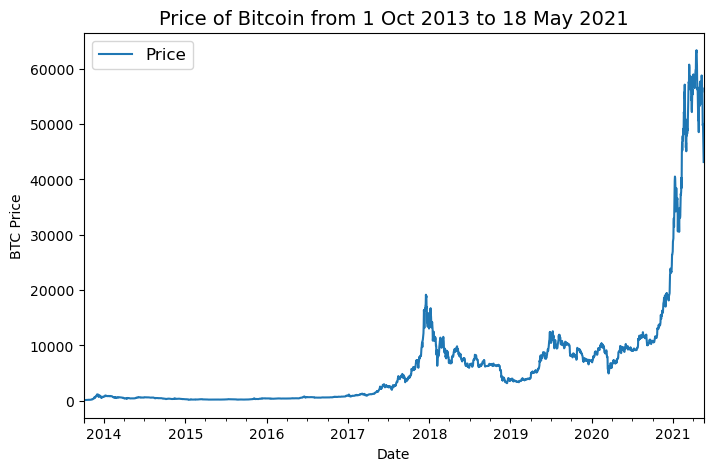

In [23]:
plot_dataframe(bitcoin_prices, "Price of Bitcoin from 1 Oct 2013 to 18 May 2021", "BTC Price")

### Train/Test Split

First, let's turn our DataFrame index and column into NumPy arrays.

In [24]:
# Get bitcoin date array
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices["Price"].to_numpy()

timesteps[:5], prices[:3]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000'], dtype='datetime64[ns]'),
 array([123.65499, 125.455  , 108.58483]))

In [25]:
# Create train and test splits the right way for time series data
split_size = int(0.8 * len(prices)) # 80% train, 20% test

# Create train data splits (everything before the split)
X_train, y_train = timesteps[:split_size], prices[:split_size]

# Create test data splits (everything after the split)
X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2229, 558, 2229, 558)

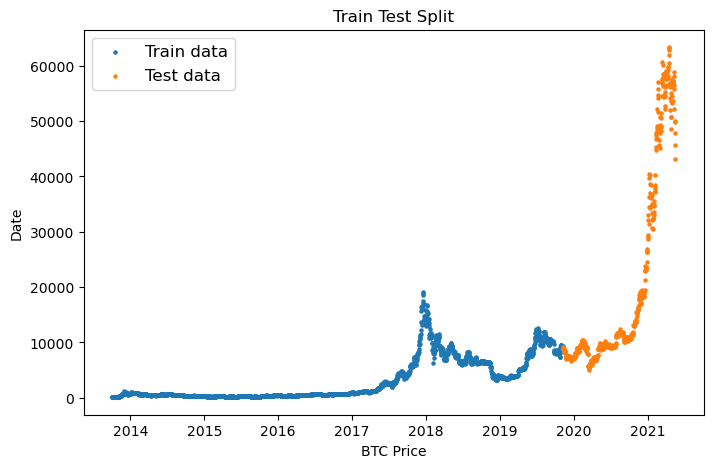

In [26]:
plot_train_vs_test(X_train, y_train, X_test, y_test, 'Train Test Split', 'Date', 'BTC Price')

We'll use the training set (past data) to train our model and evaluate its performance on the test set, which represents a simulated future.

It's important to understand that the test set is not the real future—it's a pseudofuture created from historical data. Its purpose is to give us an indication of how well our model might perform when making predictions on unseen, real future data.

By evaluating performance on this pseudofuture, we can identify issues, tune our model, and build confidence in its generalization ability—before deploying it in real-world scenarios.

<a name="3.3"></a>
### <font color='#2874a6'> <b> 3.3. Pre-processing </font> </b>

Since most models require different input data (e.g., due to different window sizes or horizons), we will perform the preprocessing immediately before building the model.

<a name="3.4"></a>
### <font color='#2874a6'> <b> 3.4. Experiments </font> </b>

We will conduct the following experiments:

| Model Number | Model Type | Horizon size | Window size |
| ----- | ----- | ----- | ----- | 
| 0 | Naïve model (baseline) | NA | NA |
| 1 | Dense model | 1 | 7 | 
| 2 | Dense model | 1 | 30 | 
| 4 | Conv1D | 1 | 7 | 
| 5 | LSTM | 1 | 7 | 
| 6 | Ensemble (multiple models optimized on different loss functions) | 1 | 7 | 


<a name="3.4.1"></a>
#### <font color='#2e86c1'> <b> 3.4.1. Model 0 (Baseline) : Naive Forecast </font> </b>

**Naive Forecast**

$$\hat{y}_{t} = y_{t-1}$$ 

In [27]:
# Create a naïve forecast
naive_forecast = y_test[:-1] # Naïve forecast equals every value excluding the last value
naive_forecast[:3], naive_forecast[-3:] # View first 3 and last 3 

(array([9226.48582088, 8794.35864452, 8798.04205463]),
 array([50032.69313676, 47885.62525472, 45604.61575361]))

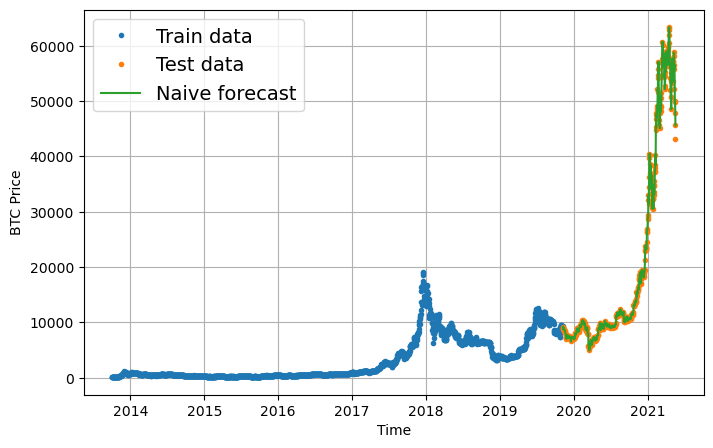

In [28]:
# Plot naive forecast
plt.figure(figsize=(8, 5))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format="-", label="Naive forecast");

Let's zoom in to take a better look.

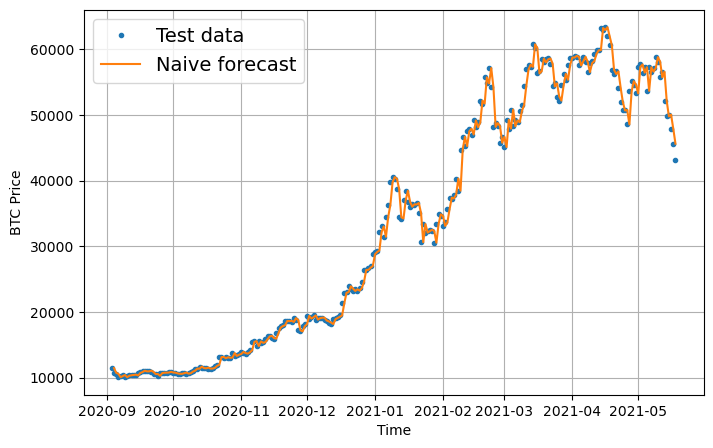

In [29]:
plt.figure(figsize=(8, 5))
offset = 300 # offset the values by 300 timesteps 
plot_time_series(timesteps=X_test, values=y_test, start=offset, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format="-", start=offset, label="Naive forecast");

We see the naïve forecast comes slightly after the test data. This makes sense because the naive forecast uses the previous timestep value to predict the next timestep value.

In [30]:
naive_results = evaluate_preds(y_true=y_test[1:],
                               y_pred=naive_forecast)
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.5165248,
 'mase': 0.99957}

Taking a look at the naïve forecast's MAE, it seems on average each forecast is ~$567 different than the actual Bitcoin price.

How does this compare to the average price of Bitcoin in the test dataset?

In [31]:
# Find average price of Bitcoin in test dataset
avg_price_test = tf.reduce_mean(y_test).numpy()
avg_price_test

20056.632963737226

In [32]:
relative_MAE = naive_results['mae']/avg_price_test
relative_MAE

0.02831882228868096

**Results**

- MAE (Mean Absolute Error): ~568

- Mean of y_test: ~20,057

- Relative MAE: 2.83%

**Interpretation**

An average error of $568 on a value around $20,000 indicates reasonable absolute accuracy, but since Bitcoin price fluctuates heavily, the MAE alone may be misleading:

- For low-volatility periods, this error could be large.

- For high-volatility periods, it might be small in comparison.

**Warning**

In volatile series like Bitcoin, relative metrics such as MAPE (Mean Absolute Percentage Error) or normalized RMSE often give better context.

-------------





REDO WITH NEW DATA







---------------------





<a name="3.4.2"></a>
#### <font color='#2e86c1'> <b> 3.4.2. Dense Model (window=7, horizon=1)</font> </b>

#### Pre-processing

In [33]:
WINDOW_SIZE = 7
HORIZON = 1

In [34]:
# windowing
full_windows_1, full_labels_1 = make_windows(prices, window_size=G.WINDOW_SIZE, horizon=G.HORIZON)
len(full_windows_1), len(full_labels_1)

(2780, 2780)

In [35]:
# View the first 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows_1[i]} -> Label: {full_labels_1[i]}")

Window: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] -> Label: [123.033]
Window: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] -> Label: [124.049]
Window: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] -> Label: [125.96116]


In [36]:
# View the last 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows_1[i-3]} -> Label: {full_labels_1[i-3]}")

Window: [58788.20967893 58102.19142623 55715.54665129 56573.5554719
 52147.82118698 49764.1320816  50032.69313676] -> Label: [47885.62525472]
Window: [58102.19142623 55715.54665129 56573.5554719  52147.82118698
 49764.1320816  50032.69313676 47885.62525472] -> Label: [45604.61575361]
Window: [55715.54665129 56573.5554719  52147.82118698 49764.1320816
 50032.69313676 47885.62525472 45604.61575361] -> Label: [43144.47129086]


In [37]:
# Train/Test Split
train_windows_1, test_windows_1, train_labels_1, test_labels_1 = make_train_test_splits(full_windows_1, full_labels_1)
train_windows_1[:3], train_labels_1[:3]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  ],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  ]]),
 array([[123.033  ],
        [124.049  ],
        [125.96116]]))

In [38]:
# Check to see if same (accounting for horizon and window size)
np.array_equal(np.squeeze(train_labels_1[:-G.HORIZON-1]), y_train[G.WINDOW_SIZE:])

True

#### Build, compile and fit the model

In [39]:
def build_compile_model_one(name, horizon=1):
    
    model = tf.keras.Sequential([
          layers.Dense(10, activation="relu"),
          layers.Dense(horizon, activation="linear") # linear activation is the same as having no activation                        
        ], name=name)
    
    model.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae"])
    
    return model

model_1 = build_compile_model_one("model_1_dense")    


In [40]:
# Fit model
history_1 = model_1.fit(
    x=train_windows_1,
    y=train_labels_1,
    epochs=10,
    #verbose=0,
    batch_size=G.BATCH_SIZE,
    validation_data=(test_windows_1, test_labels_1),
    callbacks=[
        create_model_checkpoint(model_name=model_1.name),
    ]
)

Epoch 1/10
70/70 [==============================] - 1s 11ms/step - loss: 1737.2394 - mae: 1737.2394 - val_loss: 1467.4899 - val_mae: 1467.4899
Epoch 2/10
70/70 [==============================] - 0s 6ms/step - loss: 238.8191 - mae: 238.8191 - val_loss: 1324.5632 - val_mae: 1324.5632
Epoch 3/10
70/70 [==============================] - 0s 5ms/step - loss: 226.9382 - mae: 226.9382 - val_loss: 1306.7435 - val_mae: 1306.7435
Epoch 4/10
70/70 [==============================] - 0s 6ms/step - loss: 231.1544 - mae: 231.1544 - val_loss: 1285.4701 - val_mae: 1285.4701
Epoch 5/10
70/70 [==============================] - 0s 6ms/step - loss: 219.7651 - mae: 219.7651 - val_loss: 1215.8252 - val_mae: 1215.8252
Epoch 6/10
70/70 [==============================] - 0s 2ms/step - loss: 215.6967 - mae: 215.6967 - val_loss: 1231.6324 - val_mae: 1231.6324
Epoch 7/10
70/70 [==============================] - 0s 2ms/step - loss: 212.0670 - mae: 212.0670 - val_loss: 1261.9202 - val_mae: 1261.9202
Epoch 8/10
70/70 

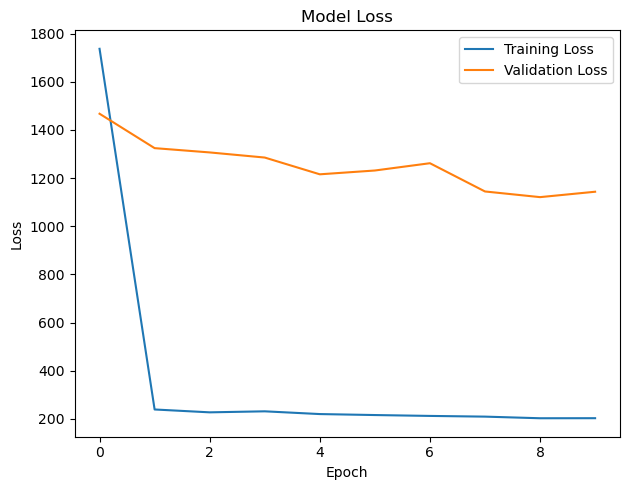

In [41]:
plot_history(history_1)

#### Load the best model


In [42]:
model_1 = tf.keras.models.load_model("model_experiments/model_1_dense")

#### Predictions and evaluation

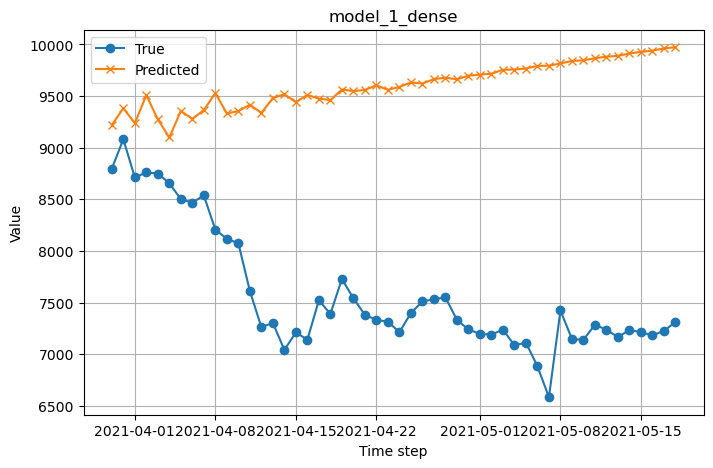

In [79]:
forecast_1, results_1 = pred_eval(model_1, test_windows_1[0], test_labels_1, X_test, 7)

In [50]:
results_1

{'mae': 2019.9751,
 'mse': 4671126.5,
 'rmse': 2161.2788,
 'mape': 27.51793,
 'mase': 13.48034}

#### Analysis

- MAE: 7,975
High absolute error — large misses in dollar terms.

- RMSE: 9,474 > MAE
Indicates presence of large outliers — the model sometimes makes very bad predictions.

- MAPE: 54.3%
On average, predictions are off by over half the true value — very poor accuracy.

- MASE: 14.0
The model performs much worse than a naive forecast (e.g., repeating last value).

This model is failing badly.



--------

REDO

-----




<a name="3.4.3"></a>
#### <font color='#2e86c1'> <b> 3.4.3. Dense Model (window=30, horizon=1)</font> </b>

Now, we will try a larger window size. Because of that, we need to adjust the data for the new model.

#### Pre-processing

In [109]:
# hyperparameters
HORIZON = 1 # predict one step at a time
WINDOW_SIZE = 30 # use 30 timesteps in the past

In [110]:
# Make windowed data with appropriate horizon and window sizes
full_windows_2, full_labels_2 = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows_2), len(full_labels_2)

(2757, 2757)

In [111]:
# Make train and testing windows
train_windows_2, test_windows_2, train_labels_2, test_labels_2 = make_train_test_splits(windows=full_windows_2, labels=full_labels_2)
train_windows_2.shape, train_labels_2.shape, test_windows_2.shape, test_labels_2.shape

((2205, 30), (2205, 1), (552, 30), (552, 1))

#### Build, compile and fit the model

In [112]:
def build_compile_model_2(name, horizon):
    
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(horizon)
    ], name=name)
    
    model.compile(loss='mae',
                  optimizer=tf.keras.optimizers.Adam())
    
    return model

model_2 = build_compile_model_2('model_2_dense', 1)

In [113]:
# fit
history_2 = model_2.fit(train_windows_2,
            train_labels_2,
            epochs=50,
            batch_size=G.BATCH_SIZE,
            verbose=0,
            validation_data=(test_windows_2, test_labels_2),
            callbacks=[create_model_checkpoint(model_name=model_2.name)])

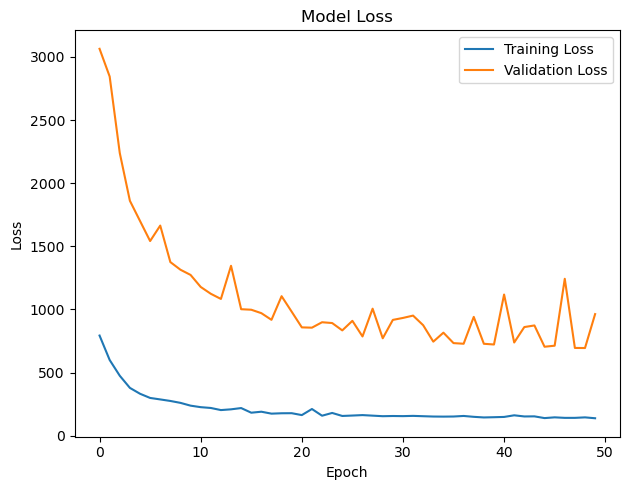

In [114]:
plot_history(history_2)

#### Load the best model

In [72]:
# Load in saved best performing model_2 and evaluate on test data
model_2 = tf.keras.models.load_model("model_experiments/model_2_dense")

#### Predictions and evaluation

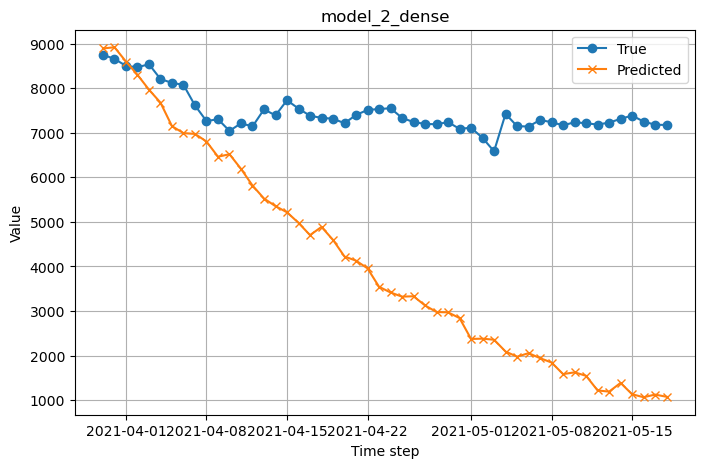

In [115]:
forecast_2, results_2 = pred_eval(model_2, test_windows_2[0], test_labels_2, X_test, WINDOW_SIZE)

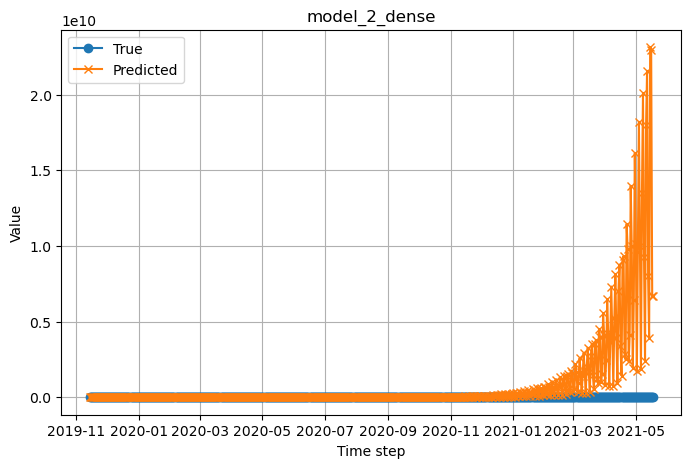

In [80]:
forecast_2_complete, results_2_complete = pred_eval(model_2, test_windows_2[0], test_labels_2, X_test, WINDOW_SIZE, len(test_labels_2))

In [116]:
results_2

{'mae': 3348.2336,
 'mse': 15367007.0,
 'rmse': 3920.0774,
 'mape': 46.076687,
 'mase': 23.730703}

#### Analysis

| Metric   | Value  | Interpretation                                                                      |
| -------- | ------ | ----------------------------------------------------------------------------------- |
| **MAE**  | 10,109 | Very high average error in dollars — worse than before.                             |
| **RMSE** | 17,497 | Much higher than MAE → indicates **severe outliers**.                               |
| **MAPE** | 34.2%  | Predictions are off by **over a third** on average — poor accuracy.                 |
| **MASE** | 17.67  | The model is performing **\~17× worse than a naive forecast** — a critical failure. |

The model’s performance has significantly degraded. Increasing the window size did not help.


-----------
redo
-------------

<a name="3.4.4"></a>
#### <font color='#2e86c1'> <b> 3.4.4. Conv1D (Window size = 7) </font> </b>

Conv1D models can be used for seq2seq (sequence to sequence) problems.

In our case, the input sequence is the previous 7 (window size) days of Bitcoin price data and the output is the next day (in seq2seq terms this is called a many to one problem).

<img src="images/CONV1D.png"/>


*Framing Bitcoin forecasting in seq2seq (sequence to sequence) terms. Using a window size greater than 1 and a horizon of one results in a many to one problem. Using a window size of >1 and a horizon of >1 results in a many to many problem.

Before we build a Conv1D model, let's recreate our datasets.

#### Pre-processing

In [81]:
HORIZON = 1 # predict next day
WINDOW_SIZE = 7 # use previous week worth of data

In [82]:
# Create windowed dataset
full_windows_4, full_labels_4 = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows_4), len(full_labels_4)

(2780, 2780)

In [83]:
# Create train/test splits
train_windows_4, test_windows_4, train_labels_4, test_labels_4 = make_train_test_splits(full_windows_4, full_labels_4)
len(train_windows_4), len(test_windows_4), len(train_labels_4), len(test_labels_4)

(2224, 556, 2224, 556)

Now, since we're going to be using Conv1D layers, we need to make sure our input shapes are correct.

The Conv1D layer in TensorFlow takes an input of: (batch_size, timesteps, input_dim).

In our case:

- The batch_size is handled automatically.

- timesteps = WINDOW_SIZE -> our model will view WINDOW_SIZE (one week) worth of past data at a time.

- input_dim = num_features -> the number of features in each timestep (e.g., temperature, humidity, etc.). In our case will be 1.

Currently, our data has the correct timesteps dimension, but we need to ensure it includes the appropriate input_dim.


In [84]:
# Check data sample shapes
train_windows_4[0].shape # returns (WINDOW_SIZE, )

(7,)

To fix this, we could adjust the shape of all of our `train_windows` or we could use a [`tf.keras.layers.Lamdba`](https://keras.io/api/layers/core_layers/lambda/) (called a Lambda layer) to do this for us in our model.

The Lambda layer wraps a function into a layer which can be used with a model.

In [85]:
# Before we pass our data to the Conv1D layer, we have to reshape it in order to make sure it works
x = tf.constant(train_windows_4[0])
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis=1)) # add an extra dimension
print(f"Original shape: {x.shape}") # (WINDOW_SIZE)
print(f"Original values: {x}")
print(f"Expanded shape: {expand_dims_layer(x).shape}") # (WINDOW_SIZE, input_dim) 
print(f"Original values with expanded shape:\n {expand_dims_layer(x)}")

Original shape: (7,)
Original values: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ]
Expanded shape: (7, 1)
Original values with expanded shape:
 [[123.65499]
 [125.455  ]
 [108.58483]
 [118.67466]
 [121.33866]
 [120.65533]
 [121.795  ]]


### Build, compile and fit the model

In [86]:
def build_compile_model_4(name, horizon):
    # Create model
    model = tf.keras.Sequential([
        # Create Lambda layer to reshape inputs, without this layer, the model will error
        layers.Lambda(lambda x: tf.expand_dims(x, axis=1)), # resize the inputs to adjust for window size / Conv1D 3D input requirements
        layers.Conv1D(filters=128, kernel_size=5, padding="causal", activation="relu"),
        layers.Dense(horizon)
    ], name=name)

    # Compile model
    model.compile(loss="mae",
                    optimizer=tf.keras.optimizers.Adam())
    
    return model
    
    
model_4 = build_compile_model_4('model_4_conv1D', HORIZON)
    

In [93]:
# fit
history_4 = model_4.fit(train_windows_4,
            train_labels_4,
            batch_size=32, 
            epochs=10,
            #verbose=0,
            validation_data=(test_windows_4, test_labels_4),
            callbacks=[create_model_checkpoint(model_name=model_4.name)])

Epoch 1/10
70/70 [==============================] - 1s 8ms/step - loss: 137.1003 - val_loss: 796.3720
Epoch 2/10
70/70 [==============================] - 0s 7ms/step - loss: 143.5290 - val_loss: 719.1678
Epoch 3/10
70/70 [==============================] - 0s 2ms/step - loss: 138.9379 - val_loss: 720.0829
Epoch 4/10
70/70 [==============================] - 1s 16ms/step - loss: 131.5805 - val_loss: 716.3777
Epoch 5/10
70/70 [==============================] - 0s 7ms/step - loss: 131.3602 - val_loss: 703.4265
Epoch 6/10
70/70 [==============================] - 0s 7ms/step - loss: 127.3471 - val_loss: 672.3481
Epoch 7/10
70/70 [==============================] - 0s 7ms/step - loss: 126.0804 - val_loss: 670.9179
Epoch 8/10
70/70 [==============================] - 0s 2ms/step - loss: 127.8685 - val_loss: 672.6770
Epoch 9/10
70/70 [==============================] - 0s 2ms/step - loss: 135.7569 - val_loss: 734.1886
Epoch 10/10
70/70 [==============================] - 0s 7ms/step - loss: 134.8670

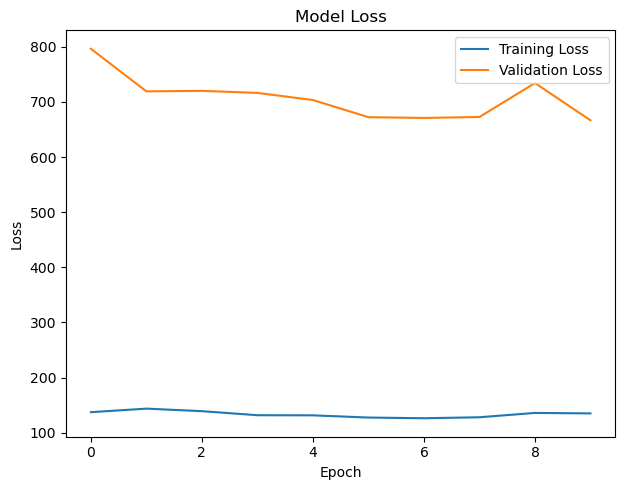

In [94]:
plot_history(history_4)

### Load the best model

In [96]:
model_4 = tf.keras.models.load_model("model_experiments/model_4_conv1D")

### Predictions and evaluations

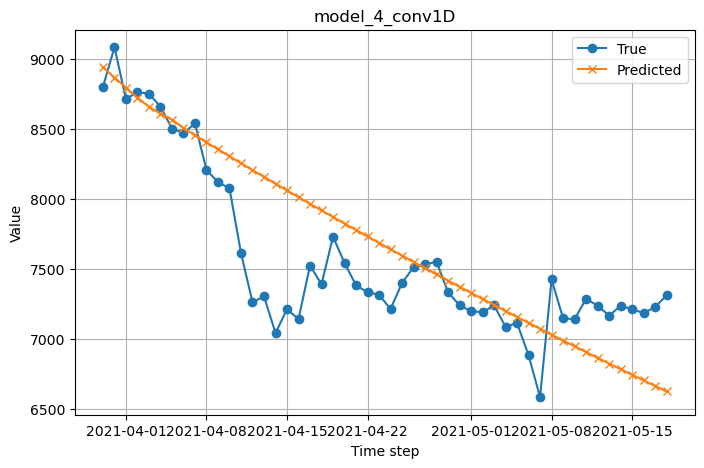

In [97]:
forecast_4, results_4 = pred_eval(model_4, test_windows_4[0], test_labels_4, X_test, WINDOW_SIZE)

### Analysis

In [98]:
results_4

{'mae': 316.3951,
 'mse': 170940.14,
 'rmse': 413.44907,
 'mape': 4.308755,
 'mase': 2.1114683}

### LSTM

In [100]:
HORIZON = 1 # predict next day
WINDOW_SIZE = 7 # use previous week worth of data

In [101]:
# Create windowed dataset
full_windows_5, full_labels_5 = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows_5), len(full_labels_5)

(2780, 2780)

In [102]:
# Create train/test splits
train_windows_5, test_windows_5, train_labels_5, test_labels_5 = make_train_test_splits(full_windows_5, full_labels_5)
len(train_windows_5), len(test_windows_5), len(train_labels_5), len(test_labels_5)

(2224, 556, 2224, 556)

In [103]:
train_windows_5.shape

(2224, 7)

### Build, compile and fit the model

In [104]:
def build_compile_model_5(name, window_size=WINDOW_SIZE, horizon=HORIZON):
    inputs = layers.Input(shape=(window_size))
    x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
        # expand input dimension to be compatible with LSTM
    x = layers.LSTM(128, activation='relu')(x)
    output = layers.Dense(horizon)(x)
    model = tf.keras.Model(inputs=inputs, outputs=output, name=name)
    
    model.compile(loss='mae',
                 optimizer=tf.keras.optimizers.Adam())
    
    return model



from tensorflow.keras import layers, models

def build_compile_model_51(name, window_size=WINDOW_SIZE, horizon=1):
    inputs = layers.Input(shape=(window_size, 1))  # sequence length & features = 1
    #x = layers.LSTM(64, activation='tanh', return_sequences=True)(inputs)
    #x = layers.Dropout(0.2)(x)
    x = layers.LSTM(128, activation='tanh')(inputs)
    #x = layers.Dropout(0.2)(x)
    output = layers.Dense(horizon)(x)
    
    model = models.Model(inputs=inputs, outputs=output, name=name)
    model.compile(loss='mae', optimizer='adam', metrics=['mae'])
    
    return model



model_5 = build_compile_model_5('model_5_lstm')

In [105]:
# fit
history_5 = model_5.fit(train_windows_5,
            train_labels_5,
            epochs=30,
            #verbose=0,
            batch_size=G.BATCH_SIZE,
            validation_data=(test_windows_5, test_labels_5),
            callbacks=[create_model_checkpoint(model_name=model_5.name)])

Epoch 1/30
70/70 [==============================] - 2s 21ms/step - loss: 911.0656 - val_loss: 1031.2474
Epoch 2/30
70/70 [==============================] - 0s 3ms/step - loss: 184.3105 - val_loss: 1118.0309
Epoch 3/30
70/70 [==============================] - 1s 18ms/step - loss: 179.3040 - val_loss: 984.2282
Epoch 4/30
70/70 [==============================] - 2s 24ms/step - loss: 173.2221 - val_loss: 976.5543
Epoch 5/30
70/70 [==============================] - 1s 20ms/step - loss: 174.0361 - val_loss: 925.5346
Epoch 6/30
70/70 [==============================] - 0s 6ms/step - loss: 162.4150 - val_loss: 934.6478
Epoch 7/30
70/70 [==============================] - 1s 19ms/step - loss: 158.1791 - val_loss: 851.5853
Epoch 8/30
70/70 [==============================] - 1s 19ms/step - loss: 151.8463 - val_loss: 813.9460
Epoch 9/30
70/70 [==============================] - 0s 3ms/step - loss: 146.3445 - val_loss: 861.0363
Epoch 10/30
70/70 [==============================] - 0s 3ms/step - loss: 1

### Load the best model

In [307]:
model_5 = tf.keras.models.load_model("model_experiments/model_5_lstm")

### Predictions and Evaluation

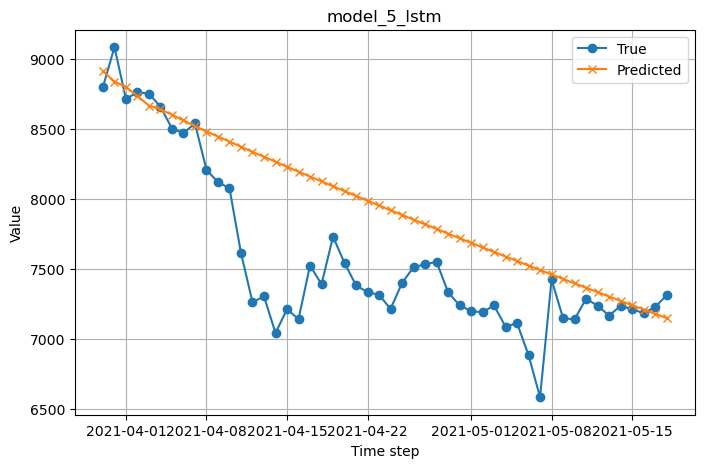

In [106]:
forecast_5, results_5 = pred_eval(model_5, test_windows_5[0], test_labels_5, X_test, 7)

In [107]:
results_5

{'mae': 399.13486,
 'mse': 264016.9,
 'rmse': 513.82574,
 'mape': 5.4476895,
 'mase': 2.6636336}

<a name="3.4.6"></a>
#### <font color='#2e86c1'> <b> 3.4.6. Ensemble </font> </b>

An **ensemble** involves training and combining multiple different models to solve the same problem.

For example, we can ensemble models that differ in:
- Loss functions (e.g., `MASE`, `MAPE`, `MAE`)
- Input window sizes (e.g., 7, 30 days)
- Random initialization (e.g., different seeds in neural networks)

The benefit of ensembling is that you get a **"wisdom of the crowd"** effect. Instead of relying on a single model’s predictions, you aggregate the outputs—often by taking the **mean** or **median**—to get more stable and often more accurate forecasts.

The key idea is **diversity**: ensembling only helps when the models bring different perspectives or behaviors.  
It wouldn’t make sense to train the exact same model 10 times on the same data and average their predictions—unless there's a source of randomness that causes the models to diverge.

Fortunately, in deep learning, **randomness is built in**. Even with the same architecture and data, models can learn differently due to (for example]):
- Random initial weights and biases
- Stochastic optimization (e.g., **stochastic gradient descent**, or SGD)

Each model starts with a random configuration and learns through a process that includes randomness (e.g., data shuffling, dropout, noisy gradients), which leads to variations in the final model.

---

#### Our Ensemble Strategy

In our case, we’ll build an ensemble using:
- Different **loss functions** (`MAE`, `MSE`, `MAPE`, etc.)
- Multiple **randomly initialized models** (same architecture, different runs)

This way, we create a **diverse set of models**, all trying to capture the underlying data dynamics, and combine their predictions for a more robust result.



### Pre-processing

In [117]:
HORIZON = 1
WINDOW_SIZE = 7

In [118]:
full_windows_5, full_labels_5 = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
train_windows_5, test_windows_5, train_labels_5, test_labels_5 = make_train_test_splits(full_windows_5, full_labels_5)

In [119]:
# Build a simple model
def build_model(horizon, loss_fn):
    """
    Builds and compiles a simple feedforward model for forecasting.

    Parameters:
        horizon (int): Number of future time steps to predict.
        loss_fn (str): Loss function to use for training.

    Returns:
        tf.keras.Model: A compiled Keras model.
    """
    model = tf.keras.Sequential([
        layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
        layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
        layers.Dense(horizon)
    ])

    model.compile(
        loss=loss_fn,
        optimizer=tf.keras.optimizers.Adam(),
        metrics=["mae", "mse"]
    )

    return model


In [121]:
def get_ensemble_models(horizon, 
                        train_windows,
                        test_windows,
                        train_labels,
                        test_labels,
                        num_iter=10, 
                        num_epochs=10, 
                        loss_fns=["mae", "mse", "mape"]):
    """
    Trains an ensemble of neural network models using different loss functions and random initializations.

    Each model in the ensemble is trained on the same data but may differ in:
    - The loss function used (from the provided `loss_fns` list)
    - The random weight initialization (due to non-deterministic training)

    Parameters:
        horizon (int): Number of time steps the model should predict.
        train_windows (array-like): Input training sequences.
        test_windows (array-like): Input validation sequences.
        train_labels (array-like): Ground truth labels for training.
        test_labels (array-like): Ground truth labels for validation.
        num_iter (int): Number of models to train per loss function (for randomization).
        num_epochs (int): Maximum number of training epochs for each model.
        loss_fns (list of str): Loss functions to use for training different models.

    Returns:
        list: A list of trained Keras models forming the ensemble.
    """
    
    ensemble_models = []

    # Train num_iter models for each loss function
    for i in range(num_iter):
        for loss_fn in loss_fns:
            print(f"Training model #{i} with loss: {loss_fn}")

            # Build and compile a model using the selected loss function
            model = build_model(horizon, loss_fn)

            # Train the model with early stopping and learning rate scheduling
            model.fit(train_windows,
                      train_labels,
                      epochs=num_epochs,
                      verbose=0,
                      validation_data=(test_windows, test_labels),
                      callbacks=[
                          tf.keras.callbacks.EarlyStopping(
                              monitor="val_loss",      # Stop if validation loss doesn't improve
                              patience=200,
                              restore_best_weights=True
                          ),
                          tf.keras.callbacks.ReduceLROnPlateau(
                              monitor="val_loss",      # Reduce learning rate if stuck
                              patience=100,
                              verbose=1
                          )
                      ])

            # Add the trained model to the ensemble
            ensemble_models.append(model)

    return ensemble_models  # Return the full list of trained models


Let's try it out by running `num_iter=5` runs for 10 epochs. This will result in 15 total models (5 for each of the 3 different loss functions).

In [122]:
%%time
# Get list of trained ensemble models
ensemble_models = get_ensemble_models(HORIZON,
                                      train_windows_5,
                                      test_windows_5,
                                      train_labels_5,
                                      test_labels_5,
                                      num_iter=5,
                                      num_epochs=10)

Training model #0 with loss: mae
Training model #0 with loss: mse
Training model #0 with loss: mape
Training model #1 with loss: mae
Training model #1 with loss: mse
Training model #1 with loss: mape
Training model #2 with loss: mae
Training model #2 with loss: mse
Training model #2 with loss: mape
Training model #3 with loss: mae
Training model #3 with loss: mse
Training model #3 with loss: mape
Training model #4 with loss: mae
Training model #4 with loss: mse
Training model #4 with loss: mape
CPU times: user 32.1 s, sys: 1.24 s, total: 33.3 s
Wall time: 26.8 s


### PRedictions

In [129]:
def make_ensemble_preds(ensemble_models, num_pred, initial_window, window_size=WINDOW_SIZE):
    """
    Generates future forecasts from each model in the ensemble.

    Parameters:
        ensemble_models (list): List of trained Keras models.
        num_pred (int): Number of time steps to predict into the future.
        initial_window (array-like): Initial input window to begin forecasting.
        window_size (int): Size of the input window for each prediction step.

    Returns:
        tf.Tensor: Tensor of shape (n_models, num_pred) with predictions from each model.
    """
    ensemble_preds = []

    for model in ensemble_models:
        # Predict into the future using the current model
        preds = make_forecast(
            model=model,
            initial_window=initial_window,
            into_future=num_pred,
            window_size=window_size,  # use parameter, not global
            verbose=False
        )
        ensemble_preds.append(preds)

    # Convert list to Tensor and remove extra dimensions if needed
    return tf.constant(tf.squeeze(ensemble_preds))


In [130]:
model_5_preds = make_ensemble_preds(ensemble_models, 50, test_windows_5[0])

In [131]:
# Aggregate ensemble predictions using the median across models
ensemble_forecast = np.median(model_5_preds, axis=0)

# Evaluate against the true future values
ensemble_results = evaluate_preds(y_true=test_labels_5[:50, 0], y_pred=ensemble_forecast)
ensemble_results


{'mae': 3347.6626,
 'mse': 15049884.0,
 'rmse': 3879.418,
 'mape': 46.006443,
 'mase': 22.340687}

In [132]:
ensemble_forecast

array([ 8841.009 ,  8830.998 ,  8856.326 ,  8931.211 ,  8948.646 ,
        9020.755 ,  9106.122 ,  9192.025 ,  9287.353 ,  9327.247 ,
        9413.982 ,  9444.444 ,  9518.38  ,  9557.437 ,  9629.87  ,
        9687.405 ,  9789.158 ,  9894.743 , 10002.376 , 10113.073 ,
       10226.692 , 10342.407 , 10460.764 , 10581.569 , 10704.639 ,
       10830.116 , 10957.86  , 11087.802 , 11219.992 , 11354.358 ,
       11490.888 , 11629.578 , 11737.627 , 11840.072 , 11943.408 ,
       12047.645 , 12152.787 , 12258.841 , 12365.828 , 12473.738 ,
       12582.592 , 12692.39  , 12803.14  , 12914.854 , 13027.541 ,
       13141.201 , 13255.8545, 13371.506 , 13488.17  , 13605.851 ],
      dtype=float32)

In [134]:
test_labels_5[:50,0]

array([8798.04205463, 9081.18687849, 8711.53433917, 8760.89271814,
       8749.52059102, 8656.97092235, 8500.64355816, 8469.2608989 ,
       8537.33965197, 8205.80636599, 8118.4885358 , 8074.84317361,
       7612.7405735 , 7262.11053495, 7303.40575852, 7041.73293642,
       7211.86180875, 7141.06944869, 7523.4806726 , 7390.20746923,
       7729.26593894, 7542.23560864, 7381.96300782, 7333.43293049,
       7315.36776456, 7213.73376172, 7398.78704961, 7511.88058312,
       7532.12351309, 7550.23919987, 7333.09604316, 7239.76257544,
       7198.06667705, 7190.27236926, 7238.87432299, 7087.02498535,
       7112.73147612, 6883.49639377, 6584.02884335, 7424.01540023,
       7147.56832379, 7139.93337053, 7286.33508116, 7236.98620461,
       7166.17237853, 7235.6266505 , 7212.80939522, 7183.70653603,
       7227.29371168, 7311.56064392])

In [137]:
model_5_preds.shape # 50 preds for each of the 15 models

TensorShape([15, 50])

<a name="4"></a>
## <font color='#1a5276'> <b> 4. Multivariate Time Series </font> </b>

Let's see if adding features helps us get better results.

This feature will vary depending on the time series you're working with. In our case, we can explore whether the Bitcoin block reward size adds any predictive value to our models.

The block reward size refers to the amount of Bitcoin awarded to miners for successfully adding a new block to the blockchain. It halves approximately every four years and could influence market behavior due to changes in supply dynamics.

Let's encode this information into our time series dataset and evaluate whether it improves model performance.

<a name="4.1"></a>
### <font color='#2874a6'> <b> 4.1. Helper Functions </font> </b>

### Plots

In [139]:
# Plot the block reward/price over time
# Note: Because of the different scales of our values we'll scale them to be between 0 and 1.
def plot_time_series_multivar(df):
    """
    args: df with price and block_reward
    """
    scaled_df = pd.DataFrame(minmax_scale(df[["Price", "block_reward"]]), # we need to scale the data first
                                     columns=df.columns,
                                     index=df.index)
    scaled_df.plot(figsize=(8, 5));
    

    
    
# plot history
def plot_history_multivar(history):

    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Plot MAE
    ax1.plot(history.history['mae'], label='Train MAE')
    ax1.plot(history.history['val_mae'], label='Validation MAE')
    ax1.set_title('Mean Absolute Error (MAE)')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('MAE')
    ax1.legend()

    # Plot MSE
    ax2.plot(history.history['mse'], label='Train MSE')
    ax2.plot(history.history['val_mse'], label='Validation MSE')
    ax2.set_title('Mean Squared Error (MSE)')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('MSE')
    ax2.legend()

    # Display plots
    plt.tight_layout()
    plt.show()

### Train/Test Split

In [140]:
def train_test_split_multivar(data, split_size=0.8):
    """
    Splits time series data into training and testing sets based on a specified split ratio,
    preserving the temporal order of the data.

    Parameters
    ----------
    data : pandas.DataFrame or pandas.Series
        The time series data with a timestamp index to be split.
    split_size : float, optional
        The proportion of data to use for the training set. Default is 0.8 (80% train, 20% test).

    Returns
    -------
    tuple
        A tuple containing:
        - train_data (numpy.ndarray): The training set values.
        - test_data (numpy.ndarray): The testing set values.
        - train_timestamps (pandas.Index): Timestamps corresponding to the training set.
        - test_timestamps (pandas.Index): Timestamps corresponding to the testing set.

    Examples
    --------
    >>> import pandas as pd
    >>> import numpy as np
    >>> index = pd.date_range(start="2022-01-01", periods=10, freq="D")
    >>> data = pd.Series(np.random.rand(10), index=index)
    >>> train_data, test_data, train_timestamps, test_timestamps = train_test_split(data, split_size=0.7)
    """
    # Determine the split point based on the test size
    split_point = int(len(data) * split_size)

    # Split the data into training and testing sets, preserving time order
    train_data = data[:split_point].values
    test_data = data[split_point:].values

    # Extract the timestamps for training and testing sets
    train_time = data.index[:split_point]
    test_time = data.index[split_point:]
    
    return train_data, test_data, train_time, test_time


### Windowing

In [141]:
def windowed_dataset_multivar(data, window_size, batch_size, shuffle_buffer, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices(data)
    
    # Create sliding windows of size window_size + 1 (for the label)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the dataset and create feature/label pairs
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    
    # Features: previous 5 values of both T and h (columns 0 and 1 respectively)
    # Target: next temperature value (T at t+1, column 0 of the last row in the window)
    dataset = dataset.map(lambda window: (window[:-1, :], window[-1, 0]))  
            # 'window[:-1, :]' gets 5 values of T and the others features, 'window[-1, 0]' gets T(t+1)
    
    # Shuffle, batch, and prefetch
    if shuffle:
        dataset = dataset.shuffle(shuffle_buffer)
    
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset


### Forecast

In [145]:
def make_forecast_multivar(model, initial_window, num_predictions, verbose=False):
    """
    Function to forecast predictions on a multivariate time series dataset, 
    where the first feature moves and the second feature remains fixed.

    Parameters:
    - model: Trained model used for forecasting.
    - initial_window: The initial input window (multivariate time series).
    - num_predictions: The number of steps to predict.
    - verbose: If True, prints additional information during predictions.

    Returns:
    - np.array: Array of predicted values for the forecasted steps.
    """
    
    predictions = []
    current_window = initial_window.copy()  # Start with the initial window

    # Make predictions until the desired number is reached
    while len(predictions) < num_predictions:
        
        # Make a prediction for one step ahead
        pred = model.predict(current_window[np.newaxis], verbose=0)
        pred_step = pred[0][0]  # Extract the predicted step (first feature)

        # Log predictions if verbose is True
        if verbose:
            print(f"Predicting on: \n {current_window} -> Prediction: {pred_step}\n")

        # Add the prediction to the list
        predictions.append(pred_step)

        # Update the window: shift the first feature and keep the second feature fixed
        current_window = np.roll(current_window, -1, axis=0)  # Shift rows to the left
        current_window[-1, 0] = pred_step  # Insert the new prediction in the first feature column

        # The second feature (index 1) stays fixed, no need to change it

    return np.array(predictions[:num_predictions])  # Return exactly num_predictions values


### Evaluation

In [143]:
# single horizon
def evaluate_preds_multivar(y_true, y_pred):
    # Make sure float32 (for metric calculations)
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)

    # Calculate various metrics
    mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
    mse = tf.keras.metrics.mean_squared_error(y_true, y_pred) # puts and emphasis on outliers (all errors get squared)
    rmse = tf.sqrt(mse)
    mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)


    return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy()}

In [146]:


# fn. that combines and plots!!!!!

def pred_eval_multivar(model, initial_window, test_labels, X_test, window_size, validation_steps=50, do_plot=True):
    
    forecast = make_forecast_multivar(model, initial_window, validation_steps, window_size)
    results = evaluate_preds_multivar(tf.squeeze(test_labels[:validation_steps]), forecast)

    if do_plot:
        plot_comparisson(X_test[-validation_steps:], test_labels[:validation_steps, 0], forecast, model.name, figsize=(8, 5))

    return forecast, results



<a name="4.2"></a>
### <font color='#2874a6'> <b> 4.2. Making a multivariate time series </font> </b>

In [147]:
# Download Bitcoin historical data from GitHub 
# Note: you'll need to select "Raw" to download the data in the correct format
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv 

--2025-07-02 20:37:22--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolviendo raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Conectando con raw.githubusercontent.com (raw.githubusercontent.com)[185.199.108.133]:443... conectado.
Petición HTTP enviada, esperando respuesta... 200 OK
Longitud: 178509 (174K) [text/plain]
Guardando como: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv.3’

BTC_USD_2013-10-01_ 100%[===================>] 174,33K  --.-KB/s    en 0,02s   

2025-07-02 20:37:22 (7,20 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv.3’ guardado [178509/178509]



In [148]:
# Parse dates and set date column to index
df = pd.read_csv("BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv", 
                 parse_dates=["Date"], 
                 index_col=["Date"]) # parse the date column (tell pandas column 1 is a datetime)
df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [149]:
# Only want closing price for each day 
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)": "Price"})
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


Time to add another feature column, the block reward size.

The following block rewards and dates were sourced from [cmcmarkets.com](https://www.cmcmarkets.com/en/learn-cryptocurrencies/bitcoin-halving).

| Block Reward | Start Date |
| ----- | ----- |
| 50 | 3 January 2009 (2009-01-03) |
| 25 | 28 November 2012 |
| 12.5 | 9 July 2016 |
| 6.25 | 11 May 2020 |
| 3.125 | TBA (expected 2024) |
| 1.5625 | TBA (expected 2028) | 

📝 Important Note on Frequency Alignment
When incorporating additional variables into a time series model—such as block rewards alongside Bitcoin prices—it's essential that all variables share the same frequency. For instance, if Bitcoin prices are recorded daily, block reward values must also be represented on a daily basis.

To achieve this, we'll assign a block reward to each date in our dataset by mapping reward values to their respective date ranges, effectively creating a daily time series for the block rewards.

🔑 Key Insight:
Always ensure that all features in a time series model are aligned in time and frequency. If one variable is at a lower frequency (e.g., weekly or event-based), you'll need to transform it (e.g., forward-fill, interpolation, or mapping to periods) so it matches the frequency of your target variable.

In [160]:
# bitcoin_prices is a DataFrame indexed by datetime64 (daily)

# Define block rewards and their effective start dates as a sorted list of tuples
block_rewards = [
    (np.datetime64("2009-01-03"), 50),      # Initial reward, not in dataset but kept for completeness
    (np.datetime64("2012-11-28"), 25),
    (np.datetime64("2016-07-09"), 12.5),
    (np.datetime64("2020-05-11"), 6.25),
]

# Make a copy of the original dataframe to avoid modifying it directly
bitcoin_prices_block = bitcoin_prices.copy()

# Initialize the block_reward column with NaN (better than None for numeric columns)
bitcoin_prices_block["block_reward"] = np.nan

# Loop through the block rewards to assign the correct reward to each date range
for i in range(len(block_rewards)):
    start_date = block_rewards[i][0]
    reward = block_rewards[i][1]

    # Determine the end date for this reward period
    if i + 1 < len(block_rewards):
        end_date = block_rewards[i + 1][0]
    else:
        end_date = bitcoin_prices_block.index[-1] + np.timedelta64(1, 'D')  # Last date + 1 day to include all

    # Assign the reward to all rows with dates >= start_date and < end_date
    mask = (bitcoin_prices_block.index >= start_date) & (bitcoin_prices_block.index < end_date)
    bitcoin_prices_block.loc[mask, "block_reward"] = reward

# Now bitcoin_prices_block has a "block_reward" column correctly aligned by date


In [161]:
bitcoin_prices_block.head()

,Price,block_reward
Date,,
2013-10-01,123.65499,25.0
2013-10-02,125.45500,25.0
2013-10-03,108.58483,25.0
2013-10-04,118.67466,25.0
2013-10-05,121.33866,25.0


In [162]:
bitcoin_prices_block.tail()

,Price,block_reward
Date,,
2021-05-14,49764.132082,6.25
2021-05-15,50032.693137,6.25
2021-05-16,47885.625255,6.25
2021-05-17,45604.615754,6.25
2021-05-18,43144.471291,6.25


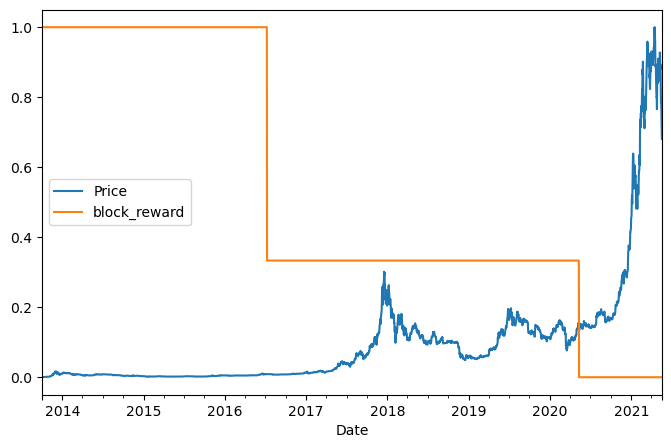

In [163]:
plot_time_series_multivar(bitcoin_prices_block)

<a name="4.3"></a>
### <font color='#2874a6'> <b> 4.3. Pre-processing </font> </b>

In [165]:
# Setup dataset hyperparameters
HORIZON = 1
WINDOW_SIZE = 7

### Train/Test Split

In [167]:
train_data, val_data, train_time, test_time = train_test_split_multivar(bitcoin_prices_block, 0.8)
len(train_data), len(val_data), len(train_time), len(test_time)

(2229, 558, 2229, 558)

In [171]:
train_data[:3], train_time[:3]

(array([[123.65499,  25.     ],
        [125.455  ,  25.     ],
        [108.58483,  25.     ]]),
 DatetimeIndex(['2013-10-01', '2013-10-02', '2013-10-03'], dtype='datetime64[ns]', name='Date', freq=None))

### Windowing

In [173]:
ds_train = windowed_dataset_multivar(train_data.astype(np.float32),WINDOW_SIZE, 32, 1000) 
ds_val = windowed_dataset_multivar(val_data.astype(np.float32), WINDOW_SIZE, 32, 1000, False)

<a name="4.4"></a>
### <font color='#2874a6'> <b> 4.4. Models </font> </b>

In [174]:
NUM_FEATURES = train_data.shape[1]
NUM_FEATURES

2

In [175]:
def build_compile_model_1(name, window_size=WINDOW_SIZE, horizon=HORIZON, num_features=NUM_FEATURES):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(128, activation='relu', input_shape=(window_size, num_features)),  
                    # input_shape should match your features
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(horizon)
    ], name=name)
    
    model.compile(
            loss='mse',
            optimizer=tf.keras.optimizers.Adam(),
            metrics=['mae','mse']
    )
    
    return model


model_1 = build_compile_model_1('Dense_Model')
model_1.summary()

Model: "Dense_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_55 (Dense)            (None, 7, 128)            384       
                                                                 
 dense_56 (Dense)            (None, 7, 64)             8256      
                                                                 
 flatten (Flatten)           (None, 448)               0         
                                                                 
 dense_57 (Dense)            (None, 1)                 449       
                                                                 
Total params: 9089 (35.50 KB)
Trainable params: 9089 (35.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [176]:
# fit
history_1 = model_1.fit(
    ds_train, 
    epochs=10, 
    verbose=0,
    validation_data=ds_val)

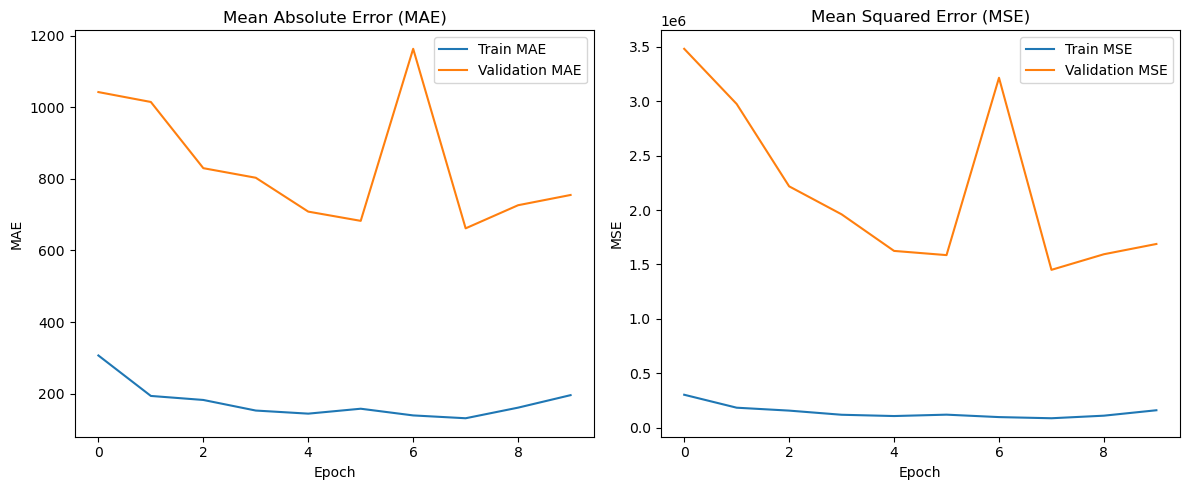

In [177]:
plot_history_multivar(history_1)

### Forecasting

In [180]:
# Set global print options to display 2 decimal places
np.set_printoptions(precision=2, suppress=True)

In [181]:
# first, let's choose an initial window
for x, _ in ds_val.take(-1):
    initial_window = x.numpy()[-1]

initial_window, initial_window.shape

(array([[55715.55,     6.25],
        [56573.55,     6.25],
        [52147.82,     6.25],
        [49764.13,     6.25],
        [50032.69,     6.25],
        [47885.62,     6.25],
        [45604.62,     6.25]], dtype=float32),
 (7, 2))

In [182]:
make_forecast_multivar(model_1, initial_window, 3, verbose=True)

Predicting on: 
 [[55715.55     6.25]
 [56573.55     6.25]
 [52147.82     6.25]
 [49764.13     6.25]
 [50032.69     6.25]
 [47885.62     6.25]
 [45604.62     6.25]] -> Prediction: 45518.9609375

Predicting on: 
 [[56573.55     6.25]
 [52147.82     6.25]
 [49764.13     6.25]
 [50032.69     6.25]
 [47885.62     6.25]
 [45604.62     6.25]
 [45518.96     6.25]] -> Prediction: 44222.109375

Predicting on: 
 [[52147.82     6.25]
 [49764.13     6.25]
 [50032.69     6.25]
 [47885.62     6.25]
 [45604.62     6.25]
 [45518.96     6.25]
 [44222.11     6.25]] -> Prediction: 43848.3125



array([45518.96, 44222.11, 43848.31], dtype=float32)

We can see that it keeps the second value fixed (we only predict the bitcoin price).

mismo número de preds qu los que saco del lote

📊 Evaluation metrics:
MAE: 1198.3687
MSE: 2199041.0000
RMSE: 1482.9164
MAPE: 16.5452


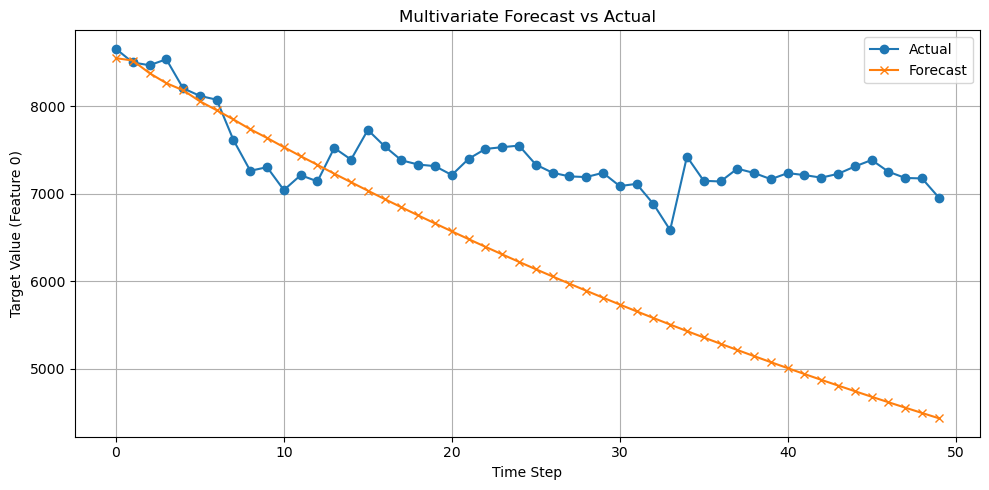

In [187]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf


val_dataset = ds_val

# === PARAMETERS ===
num_forecast_steps = 50  # How many steps ahead to forecast
sample_index = 0         # Index of the batch/sample to start from

# === Extract one sample (batch) from val dataset ===
for i, (X_batch, y_batch) in enumerate(val_dataset):
    if i == sample_index:
        initial_window = X_batch[0].numpy()  # shape: (window_size, num_features)
        y_true_values = y_batch.numpy()      # actual t+1 values in this batch
        break

# === Forecast over num_forecast_steps ===
forecast = make_forecast_multivar(
    model=model_1,
    initial_window=initial_window,
    num_predictions=num_forecast_steps,
    verbose=False
)

# === Get ground truth to compare (manually extract from the raw validation dataset) ===
# We'll extract it from the original validation dataset's labels
# You need to collect the next `num_forecast_steps` true values (first feature) from y_batch or source
y_true = []
val_iter = iter(val_dataset)

# Skip to the batch containing the initial window
for _ in range(sample_index):
    next(val_iter)

# Now collect the next `num_forecast_steps` true values
while len(y_true) < num_forecast_steps:
    X_val, y_val = next(val_iter)
    y_true.extend(y_val.numpy())

y_true = np.array(y_true[:num_forecast_steps])

# === Evaluate forecast ===
metrics = evaluate_preds_multivar(y_true, forecast)
print("📊 Evaluation metrics:")
for k, v in metrics.items():
    print(f"{k.upper()}: {v:.4f}")

# === Plotting ===
plt.figure(figsize=(10, 5))
plt.plot(y_true, label="Actual", marker='o')
plt.plot(forecast, label="Forecast", marker='x')
plt.title("Multivariate Forecast vs Actual")
plt.xlabel("Time Step")
plt.ylabel("Target Value (Feature 0)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [219]:
def get_next_labels_from_dataset_by_sample(dataset, num_steps, start_sample=0):
    """
    Extracts the next `num_steps` labels starting from a given sample index (not batch index).

    Parameters:
    - dataset: tf.data.Dataset yielding (X, y) batches.
    - num_steps: Number of label steps to extract.
    - start_sample: Number of individual samples to skip.

    Returns:
    - y_true: Numpy array of length `num_steps`, containing the true future labels.
    """
    y_true = []
    total_skipped = 0
    val_iter = iter(dataset)

    while len(y_true) < num_steps + start_sample:
        _, y_batch = next(val_iter)
        y_batch_np = y_batch.numpy()

        for label in y_batch_np:
            if total_skipped < start_sample:
                total_skipped += 1
                continue
            y_true.append(label)
            if len(y_true) == num_steps:
                break

    return np.array(y_true)


In [225]:
def pred_eval_multivar(model, initial_window, true_future, X_test=None, validation_steps=2*G.BATCH_SIZE, do_plot=True):
    """
    Forecasts using a trained multivariate model, evaluates predictions, and optionally plots the results.

    Parameters:
    - model: Trained model used for forecasting.
    - initial_window: np.array of shape (window_size, num_features)
    - true_future: np.array of shape (validation_steps,), true future values (target feature)
    - X_test: Optional index (e.g., datetime) for x-axis (length = validation_steps)
    - validation_steps: How many future steps to forecast
    - do_plot: Whether to plot predictions

    Returns:
    - forecast: predicted values (np.array)
    - results: dict of evaluation metrics
    """
    # Make forecast
    forecast = make_forecast_multivar(model, initial_window, validation_steps, verbose=False)

    # Ensure both are same shape
    #y_true = true_future[:validation_steps]
    y_pred = forecast[:validation_steps]

    y_pred = forecast

    # Evaluate
    results = evaluate_preds_multivar(y_true, y_pred)

    # Plot
    if do_plot:
        plt.figure(figsize=(8, 5))
        x_axis = X_test[-validation_steps:] if X_test is not None else np.arange(validation_steps)

        plt.plot(x_axis, y_true, label="Actual", marker='o')
        plt.plot(x_axis, y_pred, label="Forecast", marker='x')
        plt.title(f"Multivariate Forecast vs Actual — {model.name}")
        plt.xlabel("Time Step" if X_test is None else "Date")
        plt.ylabel("Target Feature (e.g. Temperature)")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return forecast, results


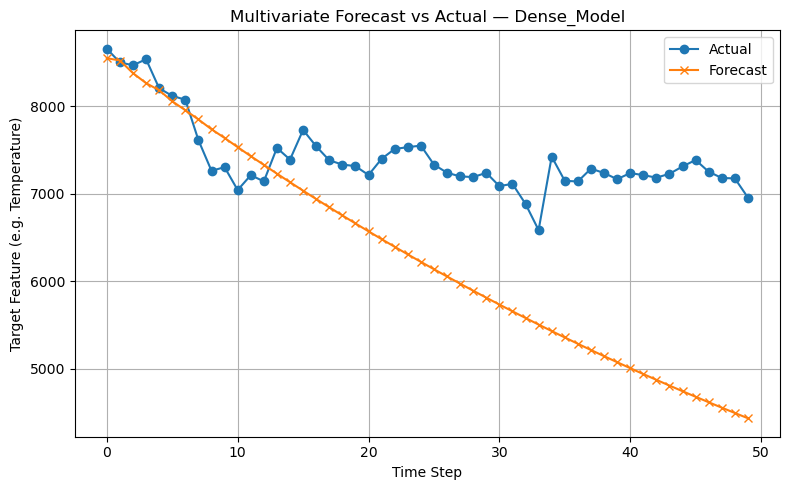

In [226]:
# Step 1: Get initial window from first batch
for x_batch, y_batch in ds_val.take(1):
    initial_window = x_batch[0].numpy()  # shape: (WINDOW_SIZE, num_features)
    break

# Step 2: Get next 50 true values (skip 1 batch since we used it)
true_future = get_next_labels_from_dataset(ds_val, num_steps=50, start_batch=1)

# Step 3: Get time axis from val_df
#start_idx = WINDOW_SIZE + 1  # +1 because we skipped 1 batch
#end_idx = start_idx + 50
#x_axis = val_df.index[start_idx:end_idx]

# Step 4: Forecast and evaluate
forecast, results = pred_eval_multivar(
    model=model_1,
    initial_window=initial_window,
    true_future=true_future,
    X_test=None,
    validation_steps=50
)



In [224]:
results

{'mae': 1198.3687, 'mse': 2199041.0, 'rmse': 1482.9164, 'mape': 16.545164}

In [191]:
def pred_eval_multivar(model, initial_window, test_labels, X_test, validation_steps=50, do_plot=True):
    """
    Makes a forecast using a trained multivariate model, evaluates the predictions, and optionally plots the results.

    Parameters:
    - model: Trained model used for forecasting.
    - initial_window: Initial multivariate window (e.g., last N time steps) of shape (window_size, num_features).
    - test_labels: True future values of the target (e.g., temperature at t+1) as a 1D array.
    - X_test: Optional second feature (e.g., humidity) to show in the plot, shape (validation_steps,).
    - validation_steps: Number of steps to forecast and evaluate.
    - do_plot: Whether to plot the forecast vs. actual values.

    Returns:
    - forecast: Numpy array of predicted values.
    - results: Dictionary with evaluation metrics.
    """
    
    # Make forecast using the multivariate method
    forecast = make_forecast_multivar(model, initial_window, validation_steps, verbose=False)

    # Evaluate predictions against the true values
    results = evaluate_preds_multivar(test_labels[:validation_steps], forecast)

    # Plot comparison if requested
    if do_plot:
        plt.figure(figsize=(8, 5))
        plt.plot(test_labels[:validation_steps], label="Actual", marker='o')
        plt.plot(forecast, label="Forecast", marker='x')
        #if X_test is not None:
        #    plt.plot(X_test[-validation_steps:], label="Feature 1 (e.g., Humidity)", linestyle="--", alpha=0.5)
        plt.title(f"Multivariate Forecast vs Actual — {model.name}")
        plt.xlabel("Time Step")
        plt.ylabel("Target Value (Feature 0)")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return forecast, results


In [99]:
"""
for LSTM
#Make sure your input data shape matches (samples, window_size, 1).
train_windows = train_windows.reshape(-1, WINDOW_SIZE, 1)
test_windows = test_windows.reshape(-1, WINDOW_SIZE, 1)
"""

'\nfor LSTM\n#Make sure your input data shape matches (samples, window_size, 1).\ntrain_windows = train_windows.reshape(-1, WINDOW_SIZE, 1)\ntest_windows = test_windows.reshape(-1, WINDOW_SIZE, 1)\n'